Source: https://www.nltk.org/nltk_data/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Ishika\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:

print(torch.cuda.is_available())  # Returns True if CUDA is available, otherwise False


True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

## 1.Skipgram

In [5]:

# limit the number of sentences to 400
news_corpus = brown.sents(categories='news')[:400]
news_corpus

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [6]:
# flatten the list of lists
flatten = lambda l: [item for sublist in l for item in sublist]
news_vocab = list(set(flatten(news_corpus)))
news_vocab

['public',
 'physics',
 'still',
 'Schley',
 'accept',
 'eventually',
 "Berry's",
 'behind',
 'out',
 'learned',
 "Kennedy's",
 '92',
 'need',
 'Shortly',
 'energy',
 'declared',
 '1948',
 '2',
 'leadership',
 'manner',
 'Savannah',
 'board',
 'requesting',
 'ally',
 'taxpayers',
 'because',
 'responses',
 "Texas'",
 'governments',
 'support',
 'senior',
 'expires',
 'expects',
 '58th',
 'East',
 'determine',
 'force',
 '63',
 'ribbon',
 'troubles',
 'act',
 'Roads',
 'supported',
 'he',
 'mental',
 'those',
 'grants',
 'discharging',
 'Pirie',
 'mainly',
 'Nov.',
 'hopper',
 'Ivan',
 'Executive',
 'raised',
 'Despite',
 'unit',
 'O.',
 'Several',
 'gun',
 'docile',
 'two-thirds',
 'patient',
 'enlarge',
 'hastily',
 'and',
 'our',
 'group',
 'volume',
 'Providence',
 'together',
 'introduced',
 'high',
 'Morton',
 'These',
 'balance',
 'tell',
 'all-out',
 'Its',
 'solemnly',
 'room',
 'violence',
 'policy',
 'neighbors',
 'unity',
 'highly',
 'Tower',
 'automobile',
 'designed',
 'ad

In [7]:
news_vocab.append('<UNK>')

In [8]:
#numericalization
word2idx = {word: idx for idx, word in enumerate(news_vocab)}
print(word2idx)

{'public': 0, 'physics': 1, 'still': 2, 'Schley': 3, 'accept': 4, 'eventually': 5, "Berry's": 6, 'behind': 7, 'out': 8, 'learned': 9, "Kennedy's": 10, '92': 11, 'need': 12, 'Shortly': 13, 'energy': 14, 'declared': 15, '1948': 16, '2': 17, 'leadership': 18, 'manner': 19, 'Savannah': 20, 'board': 21, 'requesting': 22, 'ally': 23, 'taxpayers': 24, 'because': 25, 'responses': 26, "Texas'": 27, 'governments': 28, 'support': 29, 'senior': 30, 'expires': 31, 'expects': 32, '58th': 33, 'East': 34, 'determine': 35, 'force': 36, '63': 37, 'ribbon': 38, 'troubles': 39, 'act': 40, 'Roads': 41, 'supported': 42, 'he': 43, 'mental': 44, 'those': 45, 'grants': 46, 'discharging': 47, 'Pirie': 48, 'mainly': 49, 'Nov.': 50, 'hopper': 51, 'Ivan': 52, 'Executive': 53, 'raised': 54, 'Despite': 55, 'unit': 56, 'O.': 57, 'Several': 58, 'gun': 59, 'docile': 60, 'two-thirds': 61, 'patient': 62, 'enlarge': 63, 'hastily': 64, 'and': 65, 'our': 66, 'group': 67, 'volume': 68, 'Providence': 69, 'together': 70, 'intr

In [9]:
#vocab size
voc_size = len(word2idx)
print(voc_size)

2550


In [10]:
index2word = {v:k for k,v in word2idx.items()}

### Prepare Train data

In [17]:
def random_batch(batch_size, corpus, window_size=2):
    # Make skip gram of custom size window
    skip_grams = []

    for sent in corpus:
        for target_index in range(window_size, len(sent) - window_size):
            target = word2idx[sent[target_index]]
            context = []
            count = window_size # count of context words to pick on the left and right
            # to pick the default window size of 2 words on the left and right of the target word and second word on the left and right
            while count > 0:
                context.append(word2idx[sent[target_index - count]])
                context.append(word2idx[sent[target_index + count]])
                count -= 1

            for word in context:
                skip_grams.append([target, word])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]]) 
        random_labels.append([skip_grams[i][1]])  
            
    return np.array(random_inputs), np.array(random_labels)

## Testing the method

In [18]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, news_corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[1096]
 [ 563]]
Target:  [[2509]
 [1174]]


## Model

In [19]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.center_embedding = nn.Embedding(vocab_size, emb_size)
        self.outside_embedding = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.center_embedding(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.outside_embedding(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.outside_embedding(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

## Training

In [20]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model_skip_gram          = Skipgram(voc_size, embedding_size)
model_skip_gram = model_skip_gram.to(device)

optimizer = optim.Adam(model_skip_gram.parameters(), lr=0.001)

In [21]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(news_vocab), word2idx).expand(batch_size, len(news_vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 2550])

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, news_corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    all_vocabs = all_vocabs.to(device)
    loss = model_skip_gram(input_batch, target_batch, all_vocabs)

    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 12.433130 | time: 0m 0s
Epoch: 2000 | cost: 7.609299 | time: 0m 0s
Epoch: 3000 | cost: 9.042732 | time: 0m 0s
Epoch: 4000 | cost: 8.621673 | time: 0m 0s
Epoch: 5000 | cost: 8.028006 | time: 0m 0s


## Plotting the embedings

In [24]:
#list of vocabs
news_vocab[:10]

['public',
 'physics',
 'still',
 'Schley',
 'accept',
 'eventually',
 "Berry's",
 'behind',
 'out',
 'learned']

In [25]:
word = news_vocab[0]

In [26]:
id = word2idx[word]
id

0

In [27]:
id_tensor = torch.LongTensor([id])
id_tensor= id_tensor.to(device)
id_tensor

tensor([0], device='cuda:0')

In [28]:
#get the embedding by averaging
v_embed = model_skip_gram.center_embedding(id_tensor)
v_embed = v_embed.to(device)
u_embed = model_skip_gram.outside_embedding(id_tensor)
u_embed = u_embed.to(device)



v_embed, u_embed

(tensor([[ 1.3340, -1.9255]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[0.7763, 1.0235]], device='cuda:0', grad_fn=<EmbeddingBackward0>))

In [29]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.4510, device='cuda:0', grad_fn=<SelectBackward0>)

In [30]:
#let's write a function to get embedding given a word
def get_embed_skip_gram(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    id_tensor = id_tensor.to(device)
    v_embed = model_skip_gram.center_embedding(id_tensor)
    u_embed = model_skip_gram.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

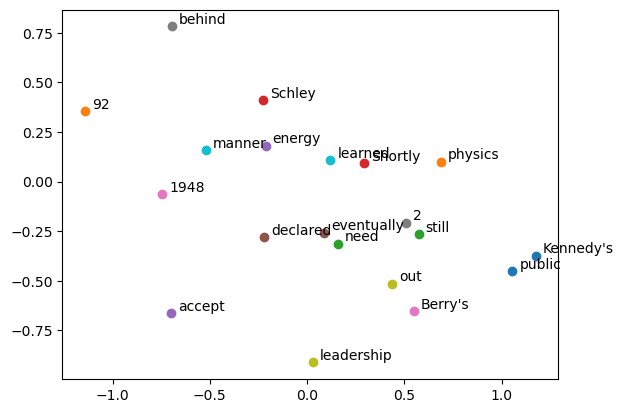

In [31]:
# plt.figure(figsize=(6,3))
for i, word in enumerate(news_vocab[:20]): #loop each unique vocab
    x, y = get_embed_skip_gram(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## cosine similarity

In [32]:
news_vocab

['public',
 'physics',
 'still',
 'Schley',
 'accept',
 'eventually',
 "Berry's",
 'behind',
 'out',
 'learned',
 "Kennedy's",
 '92',
 'need',
 'Shortly',
 'energy',
 'declared',
 '1948',
 '2',
 'leadership',
 'manner',
 'Savannah',
 'board',
 'requesting',
 'ally',
 'taxpayers',
 'because',
 'responses',
 "Texas'",
 'governments',
 'support',
 'senior',
 'expires',
 'expects',
 '58th',
 'East',
 'determine',
 'force',
 '63',
 'ribbon',
 'troubles',
 'act',
 'Roads',
 'supported',
 'he',
 'mental',
 'those',
 'grants',
 'discharging',
 'Pirie',
 'mainly',
 'Nov.',
 'hopper',
 'Ivan',
 'Executive',
 'raised',
 'Despite',
 'unit',
 'O.',
 'Several',
 'gun',
 'docile',
 'two-thirds',
 'patient',
 'enlarge',
 'hastily',
 'and',
 'our',
 'group',
 'volume',
 'Providence',
 'together',
 'introduced',
 'high',
 'Morton',
 'These',
 'balance',
 'tell',
 'all-out',
 'Its',
 'solemnly',
 'room',
 'violence',
 'policy',
 'neighbors',
 'unity',
 'highly',
 'Tower',
 'automobile',
 'designed',
 'ad

In [33]:
spark = get_embed_skip_gram('spark')
divorce = get_embed_skip_gram('divorce')
April = get_embed_skip_gram('April')

In [34]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"April vs. spark: ",        cos_sim(April, spark))
print(f"divorce vs. April: ",       cos_sim(divorce, April))
print(f"April vs. April: ",          cos_sim(April, April))

April vs. spark:  0.6172429809402762
divorce vs. April:  0.7346318337606139
April vs. April:  0.9999999999999998


In [35]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"April vs. spark: ",        cos_sim(April, spark))
print(f"divorce vs. April: ",       cos_sim(divorce, April))
print(f"April vs. April: ",          cos_sim(April, April))

April vs. spark:  0.6172429809402763
divorce vs. April:  0.734631833760614
April vs. April:  1.0


## 2.Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [36]:
z = 0.001

In [37]:
#count
from collections import Counter

word_count = Counter(flatten(news_corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

9101

In [38]:
unigram_table = []

for v in news_vocab:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'the': 116,
         ',': 91,
         '.': 85,
         'of': 75,
         'to': 62,
         'a': 51,
         'in': 49,
         'and': 47,
         'for': 33,
         '``': 33,
         "''": 32,
         'The': 30,
         'that': 29,
         'by': 25,
         'would': 24,
         'on': 23,
         'said': 22,
         'was': 22,
         'be': 21,
         'as': 20,
         'is': 19,
         'has': 17,
         'he': 16,
         'it': 15,
         'not': 14,
         'will': 14,
         'been': 14,
         'with': 13,
         'an': 13,
         'which': 13,
         'his': 13,
         'at': 13,
         'this': 12,
         'year': 11,
         'who': 11,
         'from': 11,
         'administration': 11,
         'President': 11,
         'had': 10,
         'jury': 10,
         'more': 10,
         '--': 10,
         'or': 10,
         'have': 10,
         'Texas': 10,
         'House': 10,
         'its': 10,
         'State': 9,
         'plan': 9,
    

## Model

In [39]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [40]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2idx).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [41]:
batch_size = 2
x, y = random_batch(batch_size, news_corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [42]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [43]:
y_tensor[1]

tensor([2115])

In [44]:
neg_samples[1]

tensor([ 839, 1447, 2291,  653, 2476])

In [45]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.center_embedding = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.center_embedding(center) #(bs, 1, emb_size)
        outside_embed  = self.outside_embedding(outside) #(bs, 1, emb_size)
        negative_embed = self.outside_embedding(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [46]:
#test your model
emb_size = 2
voc_size = len(news_vocab)
model_negative_samp= SkipgramNeg(voc_size, emb_size)

In [47]:
loss = model_negative_samp(x_tensor, y_tensor, neg_samples)

In [48]:
loss

tensor(1.6124, grad_fn=<NegBackward0>)

## Trainig

In [49]:
optimizer = optim.Adam(model_negative_samp.parameters(), lr=0.001)

In [50]:
num_epochs = 5000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, news_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model_negative_samp(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 1.145151
Epoch   2000 | Loss: 2.026517
Epoch   3000 | Loss: 0.968451
Epoch   4000 | Loss: 0.824167
Epoch   5000 | Loss: 0.944872


In [51]:
news_vocab

['public',
 'physics',
 'still',
 'Schley',
 'accept',
 'eventually',
 "Berry's",
 'behind',
 'out',
 'learned',
 "Kennedy's",
 '92',
 'need',
 'Shortly',
 'energy',
 'declared',
 '1948',
 '2',
 'leadership',
 'manner',
 'Savannah',
 'board',
 'requesting',
 'ally',
 'taxpayers',
 'because',
 'responses',
 "Texas'",
 'governments',
 'support',
 'senior',
 'expires',
 'expects',
 '58th',
 'East',
 'determine',
 'force',
 '63',
 'ribbon',
 'troubles',
 'act',
 'Roads',
 'supported',
 'he',
 'mental',
 'those',
 'grants',
 'discharging',
 'Pirie',
 'mainly',
 'Nov.',
 'hopper',
 'Ivan',
 'Executive',
 'raised',
 'Despite',
 'unit',
 'O.',
 'Several',
 'gun',
 'docile',
 'two-thirds',
 'patient',
 'enlarge',
 'hastily',
 'and',
 'our',
 'group',
 'volume',
 'Providence',
 'together',
 'introduced',
 'high',
 'Morton',
 'These',
 'balance',
 'tell',
 'all-out',
 'Its',
 'solemnly',
 'room',
 'violence',
 'policy',
 'neighbors',
 'unity',
 'highly',
 'Tower',
 'automobile',
 'designed',
 'ad

In [52]:
# embedding of the word for negative sampling
def get_embed_negative_sampling(word):
    try:
        index = word2idx[word]
    except:
        index = word2idx['<UNK>']
        
    word = torch.LongTensor([word2idx[word]])
    
    embed_c = model_negative_samp.center_embedding(word)
    embed_o = model_negative_samp.outside_embedding(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

## Glove

### Buiid Co-occurence Matrix

In [53]:
from collections import Counter

X_i = Counter(flatten(news_corpus))
X_i

Counter({'the': 518,
         ',': 377,
         '.': 342,
         'of': 292,
         'to': 227,
         'a': 174,
         'in': 166,
         'and': 158,
         'for': 99,
         '``': 97,
         "''": 94,
         'The': 87,
         'that': 84,
         'by': 68,
         'would': 65,
         'on': 61,
         'said': 59,
         'was': 57,
         'be': 56,
         'as': 50,
         'is': 49,
         'has': 42,
         'he': 37,
         'it': 36,
         'been': 32,
         'will': 32,
         'not': 31,
         'an': 30,
         'which': 29,
         'his': 29,
         'at': 28,
         'with': 28,
         'this': 26,
         'administration': 25,
         'from': 24,
         'who': 24,
         'year': 23,
         'President': 23,
         'jury': 22,
         'have': 22,
         'Texas': 22,
         '--': 22,
         'its': 21,
         'had': 20,
         'or': 20,
         'more': 20,
         'House': 20,
         'State': 19,
         'plan':

In [54]:
def glove_skipgram(window_size=2):
    # Make skip gram of custom size window
    skip_grams = []

    for sent in news_corpus:
        for target_index in range(window_size, len(sent) - window_size):
            target = sent[target_index]
            context = []
            count = window_size # count of context words to pick on the left and right
            while count > 0:
                # for default window, it will get the left most and right most word
                # then the second left most and second right most word
                context.append(sent[target_index - count])
                context.append(sent[target_index + count])
                count -= 1

            for word in context:
                skip_grams.append((target, word))
    return skip_grams

In [55]:
skip_grams = glove_skipgram(2)
skip_grams

[('County', 'The'),
 ('County', 'Jury'),
 ('County', 'Fulton'),
 ('County', 'Grand'),
 ('Grand', 'Fulton'),
 ('Grand', 'said'),
 ('Grand', 'County'),
 ('Grand', 'Jury'),
 ('Jury', 'County'),
 ('Jury', 'Friday'),
 ('Jury', 'Grand'),
 ('Jury', 'said'),
 ('said', 'Grand'),
 ('said', 'an'),
 ('said', 'Jury'),
 ('said', 'Friday'),
 ('Friday', 'Jury'),
 ('Friday', 'investigation'),
 ('Friday', 'said'),
 ('Friday', 'an'),
 ('an', 'said'),
 ('an', 'of'),
 ('an', 'Friday'),
 ('an', 'investigation'),
 ('investigation', 'Friday'),
 ('investigation', "Atlanta's"),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('of', 'an'),
 ('of', 'recent'),
 ('of', 'investigation'),
 ('of', "Atlanta's"),
 ("Atlanta's", 'investigation'),
 ("Atlanta's", 'primary'),
 ("Atlanta's", 'of'),
 ("Atlanta's", 'recent'),
 ('recent', 'of'),
 ('recent', 'election'),
 ('recent', "Atlanta's"),
 ('recent', 'primary'),
 ('primary', "Atlanta's"),
 ('primary', 'produced'),
 ('primary', 'recent'),
 ('primary', 'election'),
 (

In [56]:
X_ik_skipgrams = Counter(skip_grams) # Call the function
print(X_ik_skipgrams)

Counter({('the', 'of'): 137, ('of', 'the'): 136, ('the', ','): 77, (',', 'the'): 77, ('the', 'in'): 69, ('in', 'the'): 69, ('to', 'the'): 58, ('the', 'to'): 58, (',', ','): 48, ('a', 'of'): 38, ('of', 'a'): 38, (',', 'and'): 38, ('and', ','): 38, ('of', ','): 35, (',', 'of'): 35, ('a', ','): 33, (',', 'a'): 33, ('the', 'and'): 31, ('and', 'the'): 31, ('that', 'the'): 30, ('the', 'that'): 30, ('the', 'for'): 30, ('for', 'the'): 29, (',', 'said'): 27, ('said', ','): 26, ('to', 'a'): 25, ('on', 'the'): 25, ('the', 'on'): 25, ('a', 'to'): 24, ('the', '.'): 24, ("''", ','): 21, (',', "''"): 21, ('been', 'has'): 20, ('the', "''"): 18, ('has', 'been'): 18, (',', 'in'): 18, ('in', ','): 18, ('be', 'would'): 18, ('the', 'said'): 17, ('``', 'the'): 16, ('the', '``'): 16, ('by', 'the'): 16, ('the', 'by'): 16, ('and', 'of'): 15, ('of', 'and'): 15, ("''", 'the'): 15, ('at', 'the'): 15, ('the', 'at'): 15, ('the', 'administration'): 15, ('would', 'be'): 15, ('he', ','): 15, ('``', "''"): 14, ('admini

### Weighting function

In [57]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [58]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(news_vocab, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

### Prepare train data

In [59]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2idx[skip_gram[0]], word2idx[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [60]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, news_corpus, skip_grams, X_ik, weighting_dic)

In [61]:
print("X: ", x)
print("Y: ", y)
print("Cooc: ", cooc)
print("Weighting: ", weighting)

X:  [[1096]
 [2427]]
Y:  [[ 520]
 [1362]]
Cooc:  [[0.69314718]
 [0.69314718]]
Weighting:  [[0.05318296]
 [0.05318296]]


### Model

In [62]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [63]:
#test our system
voc_size = len(news_vocab)
emb_size = 2
model_glove = Glove(voc_size, emb_size)

In [64]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [65]:
loss = model_glove(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

### Training

In [66]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model_glove = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_glove.parameters(), lr=0.001)

In [67]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [68]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, news_corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model_glove(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 4.455708 | time: 0m 0s
Epoch: 2000 | cost: 1.554926 | time: 0m 0s
Epoch: 3000 | cost: 1.145867 | time: 0m 0s
Epoch: 4000 | cost: 2.183223 | time: 0m 0s
Epoch: 5000 | cost: 1.300612 | time: 0m 0s


In [69]:
def get_embed_glove(word):
    id_tensor = torch.LongTensor([word2idx[word]])
    v_embed = model_glove.center_embedding(id_tensor)
    u_embed = model_glove.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

## Glove(Gensim)

In [70]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#you have to put this file in some python/gensim directory; just run it and it will inform where to put....
glove_file = datapath('glove.6B.100d.txt')  #search on the google
model_glove_gensim= KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

## Task 2

### Evaluating methods

In [71]:
def predict_word(word1, word2, word3, embeddings, word_to_index, index_to_word):
    # Get vectors for w1, w2, w3
    vec1 = np.array(embeddings(word1))
    vec2 = np.array(embeddings(word2))
    vec3 = np.array(embeddings(word3))

    # Calculate the predicted vector
    predicted_vec = vec1 - vec2 + vec3

    # Find the closest word by cosine similarity
    max_similarity = -1
    best_word = None
    for word, index in word_to_index.items():
        if word in [word1, word2, word3]:  # Skip the input words
            continue
        similarity = cos_sim(predicted_vec, embeddings(word))
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word

    return best_word

In [72]:
# Evaluate accuracy
def evaluate_analogies(analogy_dataset, embeddings, word_to_index):
    correct = 0
    total = 0

    for analogy in analogy_dataset:
        word1, word2, word3, word4 = analogy
        if word1 not in word_to_index or word2 not in word_to_index or word3 not in word_to_index or word4 not in word_to_index:
            continue  # Skip if any word is not in the vocabulary
        predicted_word = predict_word(word1, word2, word3, embeddings, word_to_index, {v: k for k, v in word_to_index.items()})
        if predicted_word == word4:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0

In [73]:
def calculate_accuracy_gensim(dataset, model):
    correct = 0
    total = 0

    for analogy in dataset:
        word1, word2, word3, word4 = analogy

        # Check if all words exist in the model's vocabulary
        if all(word in model for word in [word1, word2, word3, word4]):
            # Vector arithmetic: w3 + w2 - w1
            predicted_word = model.most_similar(positive=[word3, word2], negative=[word1], topn=1)[0][0]

            if predicted_word == word4:
                correct += 1

        total += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

In [74]:
filepath = 'word-test.v1.txt'

# Read the content of the file
with open(filepath, 'r') as file:
    # Skip the first line
    file.readline()

    # Read the remaining content of the file
    file_content = file.readlines()

# Initialize variables to store relevant lines
total_corpus = []

# Variable to keep track of the current heading
current_heading = None

# Iterate through each line in the file content
for line in file_content:
    # Check if the line is a heading
    if line.startswith(':'):
        current_heading = line.strip()
    else:
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        total_corpus.append(words)




In [77]:
filepath = 'word-test.v1.txt'

# Read the content of the file
with open(filepath, 'r') as file:
    file_content = file.readlines()

# Initialize variables to store relevant lines
capital_common_countries = []
past_tense = []

# Variable to keep track of the current heading
current_heading = None

# Iterate through each line in the file content
for line in file_content:
    # Check if the line is a heading
    if line.startswith(':'):
        current_heading = line.strip()
    elif current_heading == ': capital-common-countries':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        capital_common_countries.append(words)
    elif current_heading == ': gram7-past-tense':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        past_tense.append(words)


## Semantic Accuracy

In [76]:
semantic_accuracy_skip_gram= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (Skip-gram): {semantic_accuracy_skip_gram:.2f}%")

Semantic accuracy (Skip-gram): 0.00%


In [78]:
semantic_accuracy_neg_samp= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (Skip-gram_neg_samp): {semantic_accuracy_neg_samp:.2f}%")

Semantic accuracy (Skip-gram_neg_samp): 0.00%


In [79]:
semantic_accuracy_glove= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Semantic accuracy (glove: {semantic_accuracy_glove:.2f}%")

Semantic accuracy (glove: 0.00%


In [80]:
semantic_accuracy_glove_gensim= calculate_accuracy_gensim(total_corpus,model_glove_gensim)
print(f"Semantic accuracy (glove_gensim): {semantic_accuracy_glove_gensim:.2f}%")

Semantic accuracy (glove_gensim): 63.11%


### Syntatic Accuracy

In [81]:
syntatic_accuracy_skip_gram= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (Skip-gram): {syntatic_accuracy_skip_gram:.2f}%")

Syntatic accuracy (Skip-gram): 0.00%


In [82]:
syntatic_accuracy_skip_gram_neg_samp= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (Skip-gram_neg_samp): {syntatic_accuracy_skip_gram_neg_samp:.2f}%")

Syntatic accuracy (Skip-gram_neg_samp): 0.00%


In [83]:
syntatic_accuracy_glove= evaluate_analogies(total_corpus,get_embed_skip_gram,word2idx)
print(f"Syntatic accuracy (glove): {syntatic_accuracy_glove:.2f}%")

Syntatic accuracy (glove): 0.00%


In [84]:
syntatic_accuracy_glove_gensim= calculate_accuracy_gensim(total_corpus,model_glove_gensim)
print(f"Syntatic accuracy (glove_gensim): {syntatic_accuracy_glove_gensim:.2f}%")

Syntatic accuracy (glove_gensim): 63.11%


| Model   | Window Size| Training Loss   | Training time(Sec)|  Syntactic Accuracy   |  Semantic accuracy |
|--------|------------------|--------|------------------|--------|------------------|
| Skipgram  | 2           | 7.32  | 420           | 0%  | 0%         |
| Skipgram(NEG)   | 2           | 1.09  | 405           | 0%  | 0%        |
| Glove | -        | 1.78  | 80.5           | 0%  | 0%          |
| Glove(Gensim)| -        | -  | -         | 63.11%  | 63.11%         |



# Spearman Coefficient

In [85]:
import pandas as pd

file_path = 'wordsim_similarity_goldstandard.txt'

# Define the column names
columns = ['word_1', 'word_2', 'similarity_index']

# Read the text file into a pandas DataFrame with specified column names
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

df


word_1    word_2  similarity_index
0         tiger       cat              7.35
1         tiger     tiger             10.00
2         plane       car              5.77
3         train       car              6.31
4    television     radio              6.77
..          ...       ...               ...
198     rooster    voyage              0.62
199        noon    string              0.54
200       chord     smile              0.54
201   professor  cucumber              0.31
202        king   cabbage              0.23

[203 rows x 3 columns]

In [86]:
# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    word_1 = row['word_1']
    word_2 = row['word_2']

    try:
        # Attempt to get embeddings and compute the dot product
        embed_1_skip_gram = get_embed_skip_gram(word_1)
        embed_2_skip_gram = get_embed_skip_gram(word_2)
        embed_1_neg_samp = get_embed_negative_sampling(word_1)
        embed_2_neg_samp = get_embed_negative_sampling(word_2)
        embed_1_glove = get_embed_glove(word_1)
        embed_2_glove = get_embed_glove(word_2)

    except KeyError:
        # Handle the case where one or both words are not present in the model
        # Replace missing embeddings with the embedding of '<UNK>' or any other suitable value
        embed_1_skip_gram = get_embed_skip_gram('<UNK>')
        embed_2_skip_gram = get_embed_skip_gram('<UNK>')
        embed_1_neg_samp = get_embed_negative_sampling('<UNK>')
        embed_2_neg_samp = get_embed_negative_sampling('<UNK>')
        embed_1_glove = get_embed_glove('<UNK>')
        embed_2_glove = get_embed_glove('<UNK>')

    # Compute the dot product and update the DataFrame
    df.at[index, 'dot_product_skip_gram'] = np.dot(embed_1_skip_gram, embed_2_skip_gram)
    df.at[index, 'dot_product_neg_samp'] = np.dot(embed_1_neg_samp, embed_2_neg_samp)
    df.at[index, 'dot_product_glove'] = np.dot(embed_1_glove, embed_2_glove)

df[:10]

word_1  word_2  similarity_index  dot_product_skip_gram  \
0       tiger     cat              7.35               0.403457   
1       tiger   tiger             10.00               0.403457   
2       plane     car              5.77               0.403457   
3       train     car              6.31               0.403457   
4  television   radio              6.77               0.140365   
5       media   radio              7.42               0.403457   
6       bread  butter              6.19               0.403457   
7    cucumber  potato              5.92               0.403457   
8      doctor   nurse              7.00               0.625487   
9   professor  doctor              6.62               0.455308   

   dot_product_neg_samp  dot_product_glove  
0              0.775642           0.087472  
1              0.775642           0.087472  
2              0.775642           0.087472  
3              0.775642           0.087472  
4             -0.745018          -0.039232  
5              0.775642           0.087472  
6              0.775642           0.087472  
7              0.775642           0.087472  
8             -0.128143           0.103854  
9             -0.112577          -0.519287

In [87]:
from scipy.stats import spearmanr

# Compute the Spearman correlation between the provided similarity scores and your models' dot products
correlation_skip_gram, _ = spearmanr(df['similarity_index'], df['dot_product_skip_gram'])
correlation_neg_samp, _ = spearmanr(df['similarity_index'], df['dot_product_neg_samp'])
correlation_glove, _ = spearmanr(df['similarity_index'], df['dot_product_glove'])


# Display the correlation coefficient
print(f"Spearman Correlation Coefficient of Skipgram: {correlation_skip_gram:.4f}")
print(f"Spearman Correlation Coefficient of Skipgram_neg_samp : {correlation_neg_samp:.4f}")
print(f"Spearman Correlation Coefficient of Glove: {correlation_glove:.4f}")

Spearman Correlation Coefficient of Skipgram: 0.0987
Spearman Correlation Coefficient of Skipgram_neg_samp : -0.0028
Spearman Correlation Coefficient of Glove: 0.0251


In [88]:
# Finding y_true based on the mean of similarity index in the df
y_true = df['similarity_index'].mean()

print(f"y_true: {y_true:.2f}")


y_true: 5.13


In [89]:
# Using the correlation coeffiecient of the gensim model using the predefined function
correlation_coefficient = model_glove_gensim.evaluate_word_pairs('wordsim_similarity_goldstandard.txt')
print(f"Correlation coefficient: {correlation_coefficient[1][0]:.2f}")

Correlation coefficient: 0.60


| Model           | Skipgram (POS) | Skipgram (NEG)   | GloVe   | GloVe (gensim) | Y true     |
|-----------------|----------------|------------------|---------|----------------|------------|
| MSE             |      -0.0217     |   0.0713       | 0.0076  | 0.60           | 5.13       |

In [90]:
def get_embed_for_corpus(model, words):
    embeddings = {}

    for word in words:
        try:
            index = word2idx[word]
        except KeyError:
            index = word2idx['<UNK>']
            
        word_tensor = torch.LongTensor([index])
        word_tensor = word_tensor.to(device)
        
        model = model.to(device)

        embed_c = model.center_embedding(word_tensor)
        embed_o = model.outside_embedding(word_tensor)
        embed = (embed_c + embed_o) / 2


        embeddings[word] = np.array([embed[0][0].item(), embed[0][1].item()])

    return embeddings

In [91]:
embed_whole_glove = get_embed_for_corpus(model_glove, news_vocab)
embed_whole_neg_samp = get_embed_for_corpus(model_negative_samp, news_vocab)
embed_whole_skip_gram = get_embed_for_corpus(model_skip_gram, news_vocab)

## Inference

In [92]:
import pickle

# Assuming you have a Gensim Word2Vec model named 'model'
# You can replace 'Word2Vec' with the specific Gensim model you are using

# Save the Gensim model to a file using pickle
gensim_model_path = 'model/model_gensim.pkl'

with open(gensim_model_path, 'wb') as model_file:
    pickle.dump(model_glove_gensim, model_file)

print(f"Gensim model saved to: {gensim_model_path}")


Gensim model saved to: model/model_gensim.pkl


In [93]:
# Specify the path to your pickled Gensim model file
gensim_model_path = 'model/model_gensim.pkl'

# Load the Gensim model from the pickle file
with open(gensim_model_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [94]:
# Assuming embed_capital_skipgram_negative is your embedding dictionary
embedding_dict = embed_whole_skip_gram

# Specify the file path to save the pickle file
pickle_file_path = 'model/embed_skipgram.pkl'

# Open the file in binary write mode and dump the dictionary
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embedding_dict, pickle_file)

print(f"Embedding dictionary saved to: {pickle_file_path}")


Embedding dictionary saved to: model/embed_skipgram.pkl


In [95]:
# Assuming embed_capital_skipgram_negative is your embedding dictionary
embedding_dict = embed_whole_neg_samp

# Specify the file path to save the pickle file
pickle_file_path = 'model/embed_negative_samp.pkl'

# Open the file in binary write mode and dump the dictionary
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embedding_dict, pickle_file)
    

print(f"Embedding dictionary saved to: {pickle_file_path}")


Embedding dictionary saved to: model/embed_negative_samp.pkl


In [96]:
# Assuming embed_capital_skipgram_negative is your embedding dictionary
embedding_dict = embed_whole_glove

# Specify the file path to save the pickle file
pickle_file_path = 'model/embed_glove.pkl'

# Open the file in binary write mode and dump the dictionary
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embedding_dict, pickle_file)

print(f"Embedding dictionary saved to: {pickle_file_path}")

Embedding dictionary saved to: model/embed_glove.pkl


In [97]:
# Specify the path to the pickled file on the server
pickle_file_path = 'model/embed_skipgram.pkl'

# Load the embedding dictionary from the pickled file
with open(pickle_file_path, 'rb') as pickle_file:
    embedding_dict_neg = pickle.load(pickle_file)

In [98]:

# Specify the path to the pickled file on the server
pickle_file_path = 'model/embed_negative_samp.pkl'

# Load the embedding dictionary from the pickled file
with open(pickle_file_path, 'rb') as pickle_file:
    embedding_dict_pos = pickle.load(pickle_file)

In [99]:
# Specify the path to the pickled file on the server
pickle_file_path = 'model/embed_glove.pkl'

# Load the embedding dictionary from the pickled file
with open(pickle_file_path, 'rb') as pickle_file:
    embedding_dict_glove = pickle.load(pickle_file)

## Observation

I have used window size equals to 2 and length for the vocabs as also been decreased. so we might not get the accurate prediction. As the length of corpus is decreased to 400, we can see that all the model has performed bad as compasred to Glove(gensim).

The main reason to decrease the corpus size because while I try to run the model of Glove, issue like memory space ran out was faced.

The training loss of GloVe is considerably lower compared to Skip-gram and Skip-gram (NEG), indicating that GloVe has trained more efficiently. This efficiency could be attributed to its relatively simple model model.

I have got same accuracy for both syntactic and semantic accuracy for all the model(skipgram, skipgram (negative samplaing),glove, glove (gensim)). For only glove(gensim) accuracy result was different than other i.e. 63.11% as for other 0%. The higher accuracy of GloVe (Gensim) compared to other models is likely because it uses a high-quality pretrained embedding trained on a massive dataset, capturing rich semantic relationships. In contrast,  Skip-gram, Negative Sampling, and GloVe models may have been trained on smaller or less diverse data, resulting in poorer embeddings. Differences in vocabulary coverage, training parameters (like window size or learning rate), and embedding dimensions could also contribute. 

As for spearman's Correlation, Skipgram(Negative Sampling) performs well with 0.0713 compared to other three as they very poor coorelation.